# 주요 내용
### 코랩 실행환경 사양 확인하는 코드 추가
### 용어 통일 (training → train)
### "korean speaks korean" dataset을 이용하여 학습한 모델로 "korean speaks english" dataset을 분류하는 실험 진행 (범용성 확인)
### → # of train data == 5000, # of test data == 5000

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4578888896929231785, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11329076510406590291
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7716802783865621864
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14539337746169289722
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
import platform
platform.platform()

'Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic'

In [4]:
  !nvidia-smi

Thu Apr  2 15:24:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    58W / 149W |    130MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import os

train_pcm_path = "./train_pcm_dataset"
train_wav_path = "./train_wav_dataset"

test_pcm_path = "./test_pcm_dataset"
test_wav_path = "./testwav_dataset"

# mkdir
if not os.path.exists(train_pcm_path):
    os.mkdir(train_pcm_path)

if not os.path.exists(train_wav_path):
    os.mkdir(train_wav_path)

if not os.path.exists(test_pcm_path):
    os.mkdir(test_pcm_path)

if not os.path.exists(test_wav_path):
    os.mkdir(test_wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./train_pcm_dataset" # korean speaks korean
!unzip -q "/content/drive/My Drive/ETRI/8_voice_download_4_Korean_English_by_Korean_part1.zip" -d "./test_pcm_dataset"  # korean speaks english

print(os.listdir(train_pcm_path)[:5])
print(len(os.listdir(train_pcm_path)))

print(os.listdir(test_pcm_path)[:5])
print(len(os.listdir(test_pcm_path)))

['I4F07852PKJ0', 'GSM03224CHD0', 'GSM03634SJY0', 'GSF03031LJH0', 'GSF06742CKA0']
50
['I4F07852PKJ0', 'GSM03224CHD0', 'GSM03634SJY0', 'GSF03031LJH0', 'GSF06742CKA0']
50


In [8]:
print(os.listdir(train_pcm_path) == os.listdir(test_pcm_path))

True


In [9]:
# pcm to wav

import wave

for i, folder_path in enumerate(os.listdir(train_pcm_path)):
    file_list = os.listdir(os.path.join(train_pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(file_list_pcm):
        with open(os.path.join(train_pcm_path, folder_path, file_path), 'rb') as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(train_wav_path, '{}_{}.wav'.format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

for i, folder_path in enumerate(os.listdir(test_pcm_path)):
    file_list = os.listdir(os.path.join(test_pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(file_list_pcm):
        with open(os.path.join(test_pcm_path, folder_path, file_path), 'rb') as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(test_wav_path, '{}_{}.wav'.format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(train_wav_path)[:5])
print(len(os.listdir(train_wav_path)))

print(os.listdir(test_wav_path)[:5])
print(len(os.listdir(test_wav_path)))

['13_22.wav', '1_34.wav', '22_39.wav', '27_12.wav', '32_88.wav']
5000
['13_22.wav', '1_34.wav', '22_39.wav', '27_12.wav', '32_88.wav']
5000


In [0]:
# initialized values

import numpy as np

num_labels = 50
num_features = 100
sr = 16000
duration = 1

num_train_data = num_features
num_test_data = num_features

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

In [12]:
# save features as *.npz format

from scipy.io import wavfile

train_data = np.zeros((num_labels * num_train_data, duration * sr))
train_labels = np.zeros((num_labels * num_train_data))

test_data = np.zeros((num_labels * num_test_data, duration * sr))
test_labels = np.zeros((num_labels * num_test_data))

# save train data
for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(train_wav_path, file_name))
        
        # extract 1 sec (i.e. 'duration * sr' length) of each files
        start = int(len(samples)//2 - duration * sample_rate / 2)
        end = int(len(samples)//2 + duration * sample_rate / 2)

        train_data[i * num_train_data + j] = samples[start:end]
        train_labels[i * num_train_data + j] = i

# save test data
for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(test_wav_path, file_name))
        
        # extract 1 sec (i.e. 'duration * sr' length) of each files
        start = int(len(samples)//2 - duration * sample_rate / 2)
        end = int(len(samples)//2 + duration * sample_rate / 2)

        test_data[i * num_train_data + j] = samples[start:end]
        test_labels[i * num_train_data + j] = i
        

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print('train_data.shape: {}, train_labels.shape: {}'.format(train_data.shape, train_labels.shape))
print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, train_labels.shape))

train_data.shape: (5000, 16000), train_labels.shape: (5000,)
test_data.shape: (5000, 16000), test_labels.shape: (5000,)


In [0]:
# generate model as a function

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

def build_model():
    model = Sequential()
    model.add(layers.Conv1D(16, 5, activation = 'relu', input_shape = (sr * duration, 1)))
    model.add(layers.MaxPooling1D(5))

    model.add(layers.Conv1D(32, 7, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(5))

    model.add(layers.Conv1D(64, 7, activation = 'relu'))
    model.add(layers.MaxPooling1D(5))

    model.add(layers.Conv1D(128, 7, activation = 'relu'))
    model.add(layers.Conv1D(128, 8, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalMaxPooling1D())

    model.add(layers.Dense(num_labels, activation = 'softmax'))

    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [14]:
# split train & test data/labels

from tensorflow.keras.utils import to_categorical

len_data = train_data.shape[1] # i.e. sr * duration

n_splits = 5
num_val_samples = num_train_data // n_splits # i.e. 80 * 0.2 = 16

batch_size = 80
epochs = 100

all_history = []

for i in range(n_splits):
    print('처리중인 폴드 #{}'.format(i))

    # data saperating
    partial_X_vals = [train_data[j::num_train_data] for j in range(i * num_val_samples, (i+1) * num_val_samples)]
    partial_Y_vals = [train_labels[j::num_train_data] for j in range(i * num_val_samples, (i+1) * num_val_samples)]

    partial_X_trains = [train_data[j::num_train_data] for j in range(i * num_val_samples)]
    partial_X_trains += [train_data[j::num_train_data] for j in range((i+1) * num_val_samples, num_train_data)]

    partial_Y_trains = [train_labels[j::num_train_data] for j in range(i * num_val_samples)]
    partial_Y_trains += [train_labels[j::num_train_data] for j in range((i+1) * num_val_samples, num_train_data)]

    X_train = np.concatenate(partial_X_trains, axis = 0)
    Y_train = np.concatenate(partial_Y_trains, axis = 0)
    
    X_val = np.concatenate(partial_X_vals, axis = 0)
    Y_val = np.concatenate(partial_Y_vals, axis = 0)

    print('sperating validation data arange: [{}, {}]'.format(i * num_val_samples, (i+1) * num_val_samples - 1))

    # data reshaping
    x_train = X_train.reshape(len(X_train), len_data, 1)
    x_val = X_val.reshape(len(X_val), len_data, 1) 

    y_train = to_categorical(Y_train)
    y_val = to_categorical(Y_val)

    # standarization
    mean = x_train.mean()
    x_train -= mean
    std = x_train.std()
    x_train /= std

    x_val -= mean
    x_val /= std 

    # build model
    model = build_model()
    history = model.fit(x_train, y_train,
                        validation_data = (x_val, y_val),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 0)
    
    all_history.append(history)

처리중인 폴드 #0
sperating validation data arange: [0, 19]
처리중인 폴드 #1
sperating validation data arange: [20, 39]
처리중인 폴드 #2
sperating validation data arange: [40, 59]
처리중인 폴드 #3
sperating validation data arange: [60, 79]
처리중인 폴드 #4
sperating validation data arange: [80, 99]


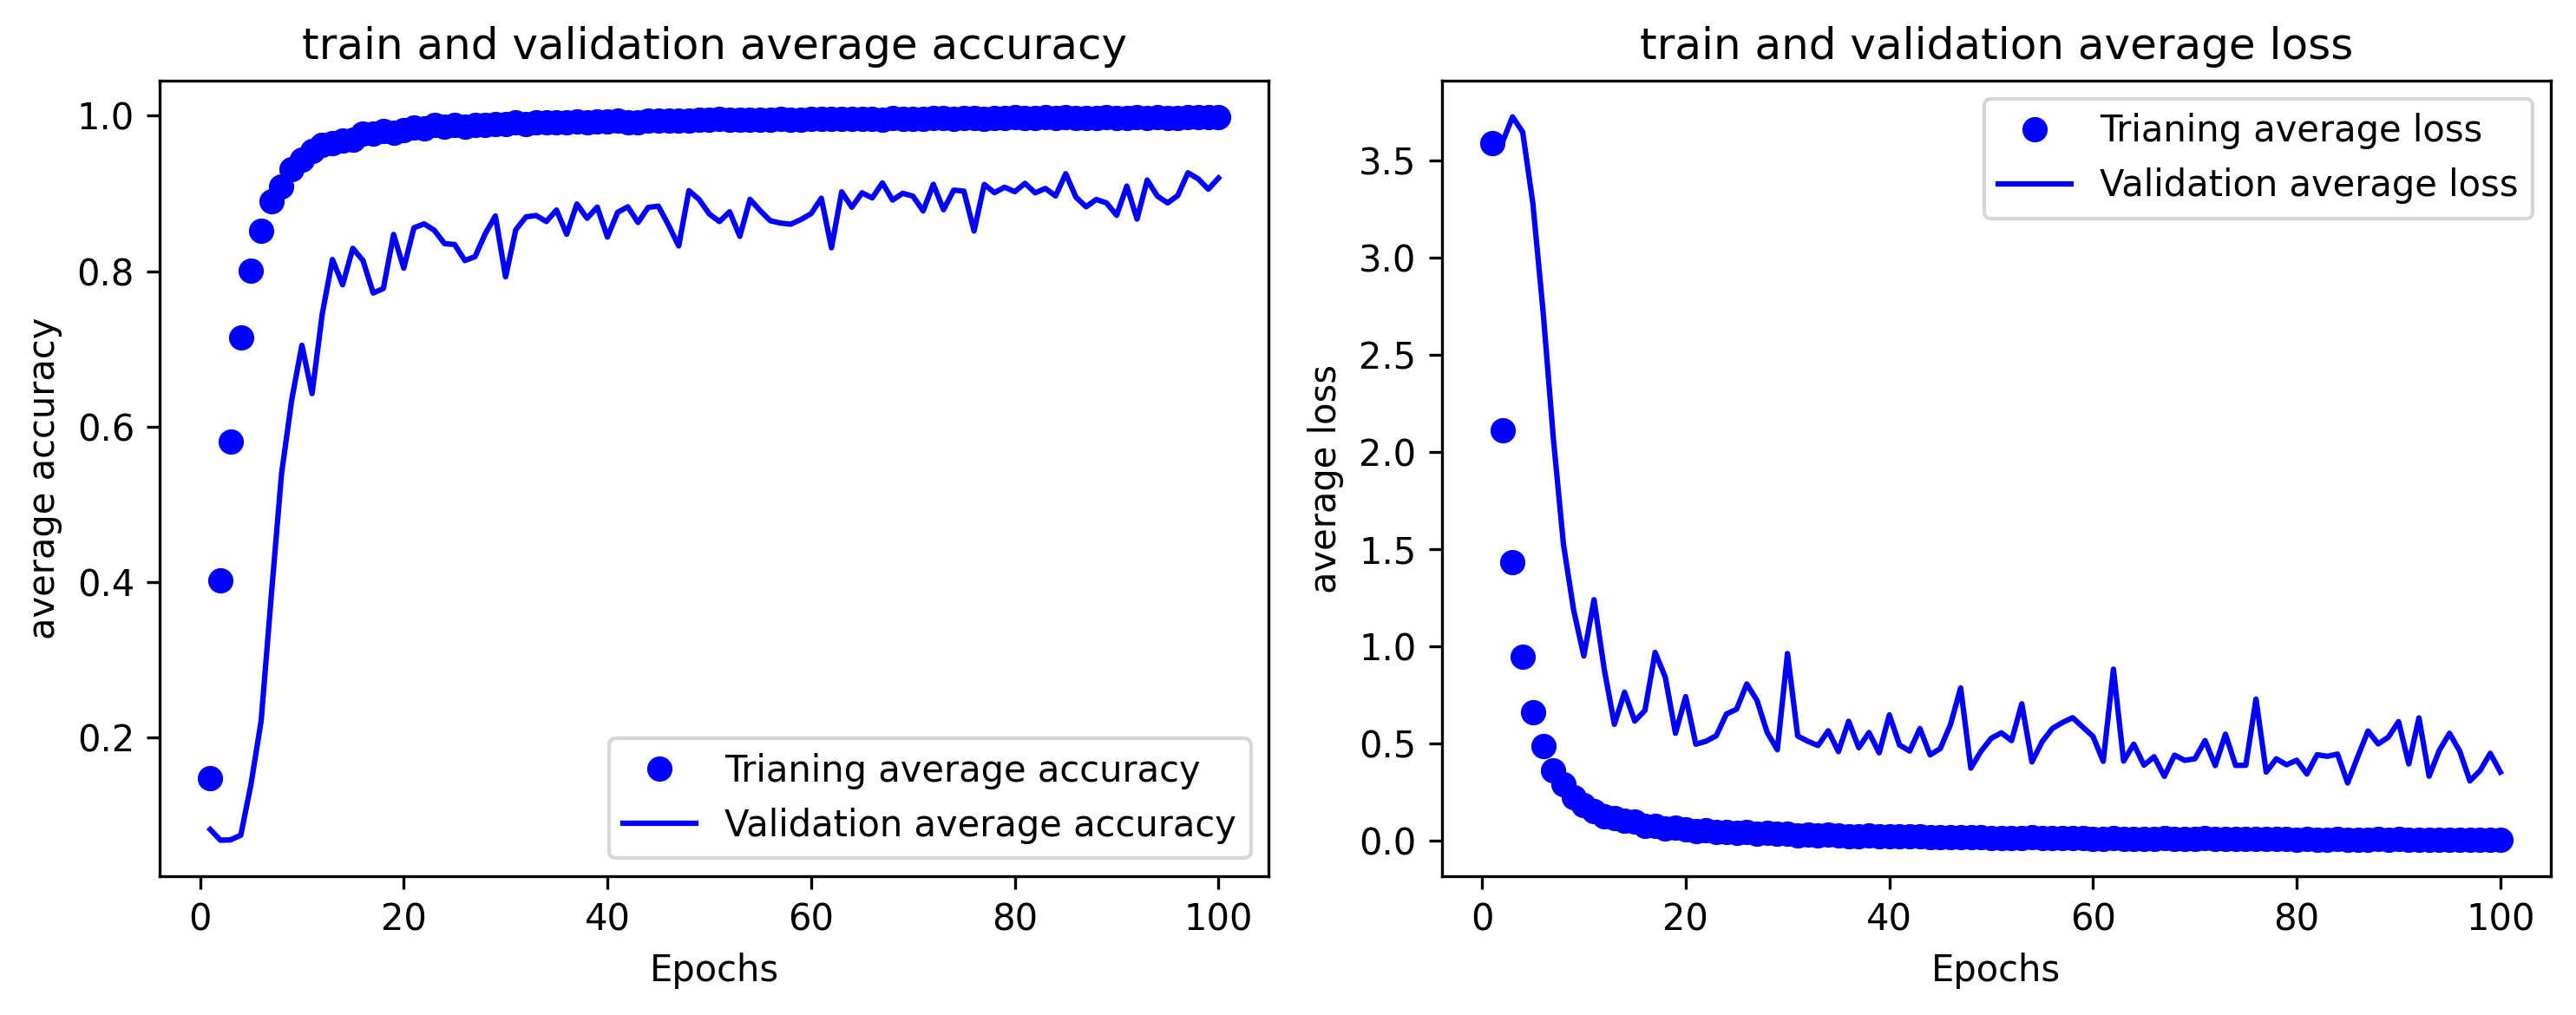

In [15]:
# plot

import matplotlib.pyplot as plt

# calculate average
acc = [all_history[i].history['accuracy'] for i in range(n_splits)]
avg_acc = [np.mean([x[i] for x in acc]) for i in range(epochs)]

val_acc = [all_history[i].history['val_accuracy'] for i in range(n_splits)]
avg_val_acc = [np.mean([x[i] for x in val_acc]) for i in range(epochs)]

loss = [all_history[i].history['loss'] for i in range(n_splits)]
avg_loss = [np.mean([x[i] for x in loss]) for i in range(epochs)]

val_loss = [all_history[i].history['val_loss'] for i in range(n_splits)]
avg_val_loss = [np.mean([x[i] for x in val_loss]) for i in range(epochs)]

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# average accuracy & average validation accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), avg_acc, 'bo', label = 'Trianing average accuracy')
plt.plot(range(1, epochs + 1), avg_val_acc, 'b', label = 'Validation average accuracy')
plt.title('train and validation average accuracy')
plt.xlabel('Epochs')
plt.ylabel('average accuracy')
plt.legend()

# average loss & average validation loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), avg_loss, 'bo', label = 'Trianing average loss')
plt.plot(range(1, epochs + 1), avg_val_loss, 'b', label = 'Validation average loss')
plt.title('train and validation average loss')
plt.xlabel('Epochs')
plt.ylabel('average loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# evaluate as test data

# reshaping
train_data = train_data.reshape(len(train_data), len_data, 1)
train_labels = to_categorical(train_labels)

test_data = test_data.reshape(len(test_data), len_data, 1)
test_labels = to_categorical(test_labels)

# standarization
mean = train_data.mean()
train_data -= mean
std = train_data.std()
train_data /= std

test_data -= mean
test_data /= std 

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (5000, 16000, 1), test_labels.shape: (5000, 50)


In [17]:
# build model

batch_size = 80
epochs = 100

model = build_model()
model.fit(train_data, train_labels,
          epochs = epochs, batch_size = batch_size, verbose = 0)

# evaluate
results = model.evaluate(test_data, test_labels, batch_size = batch_size)

print('test loss, test acc:', results)

63/63 [==============================] - 2s 24ms/step - loss: 2.6780 - accuracy: 0.6692
test loss, test acc: [2.6779634952545166, 0.6692000031471252]
